# Предсказание оттока пользователей сотового оператора.

Загрузим датасет с информацией о пользователях оператора и сначала при помощи логистической регрессии, а затем при помощи CatBoost, предскажем уйдет ли пользователь от этого оператора или нет.

### Анализ и подготовка данных

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
!pip install catboost

In [16]:
data = pd.read_csv('./train.csv')

In [17]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = ['Churn']
cols = feature_cols + target_col
data = data[cols]
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Проверим, есть ли в датасете пропущенные значения.

In [5]:
data.isna().mean()

ClientPeriod                0.0
MonthlySpending             0.0
TotalSpent                  0.0
Sex                         0.0
IsSeniorCitizen             0.0
HasPartner                  0.0
HasChild                    0.0
HasPhoneService             0.0
HasMultiplePhoneNumbers     0.0
HasInternetService          0.0
HasOnlineSecurityService    0.0
HasOnlineBackup             0.0
HasDeviceProtection         0.0
HasTechSupportAccess        0.0
HasOnlineTV                 0.0
HasMovieSubscription        0.0
HasContractPhone            0.0
IsBillingPaperless          0.0
PaymentMethod               0.0
Churn                       0.0
dtype: float64

Пропущенных значений не найдено. Проверим типы всех признаков.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Численный признак TotalSpent имеет тип object, что говорит нам о том, что среди значений присутствуют нечисловые. Посмотрим распредление всех значений в TotalSpent.

In [7]:
data['TotalSpent'].value_counts()

           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64

Среди значений есть пробелы, заменим их на нули и приведйм всй к типу float.

In [18]:
data['TotalSpent'] = data['TotalSpent'].replace(' ', '0').astype(float)

Теперь данные готовы к последующей обработке.

Построим гистограмму для численных признаков.

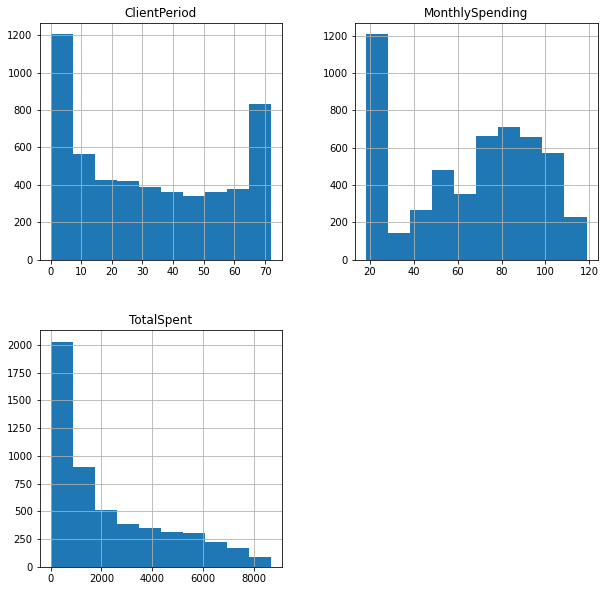

In [9]:
data.hist(column=num_cols, figsize=(10, 10))
None

Посмотрим распределение категориальных признаков и построим круговые диаграммы.

Sex DISTRIBUTION
Male      2655
Female    2627
Name: Sex, dtype: int64

IsSeniorCitizen DISTRIBUTION
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

HasPartner DISTRIBUTION
No     2705
Yes    2577
Name: HasPartner, dtype: int64

HasChild DISTRIBUTION
No     3676
Yes    1606
Name: HasChild, dtype: int64

HasPhoneService DISTRIBUTION
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

HasMultiplePhoneNumbers DISTRIBUTION
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

HasInternetService DISTRIBUTION
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

HasOnlineSecurityService DISTRIBUTION
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

HasOnlineBackup DISTRIBUTION
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dty

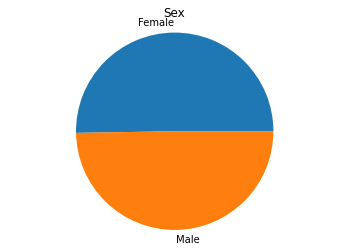

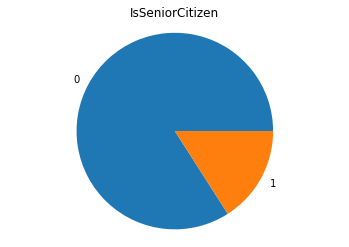

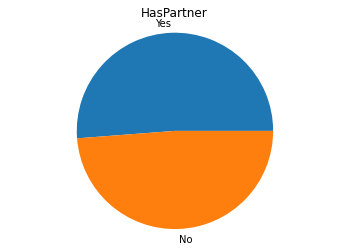

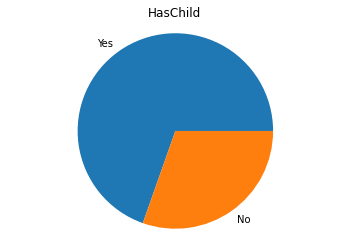

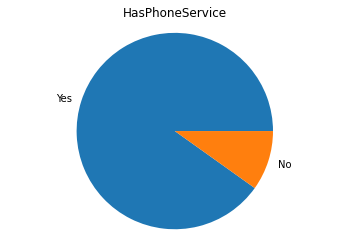

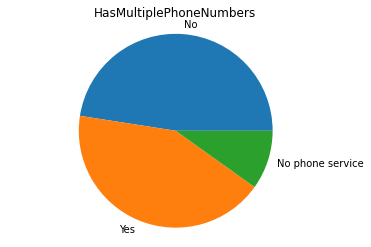

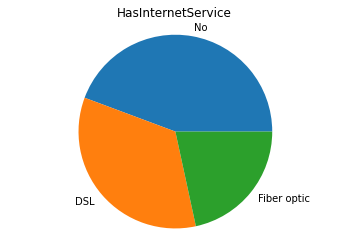

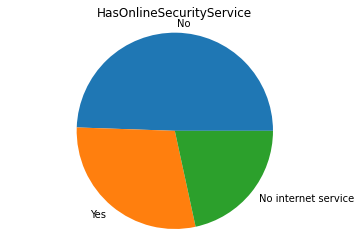

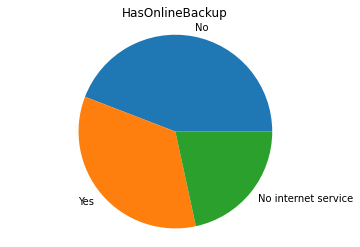

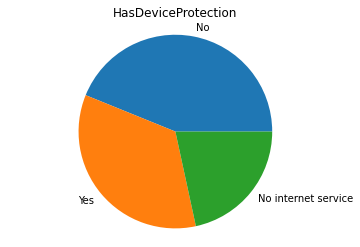

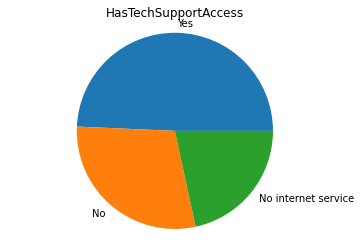

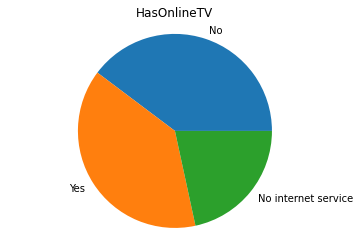

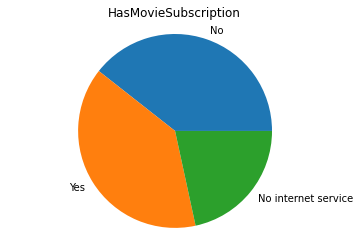

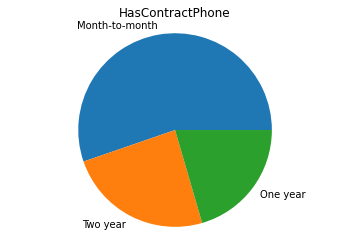

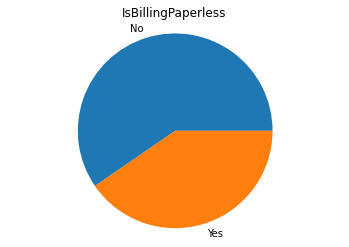

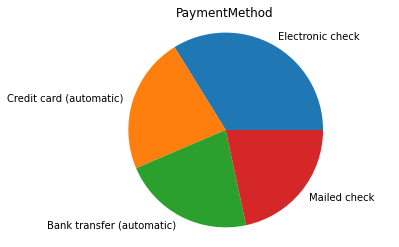

In [10]:
for col in cat_cols:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()
for col in cat_cols:
    fig1, ax1 = plt.subplots()
    labels = set(data[col])
    ax1.pie(data[col].value_counts(), labels = labels)
    ax1.axis('equal')
    plt.title(str(col))
    plt.show()

Посмотрим сбалансированность классов.

In [11]:
data[target_col].value_counts()

Churn
0        3898
1        1384
dtype: int64

По распредлению значений у целевой переменной можно сказать, что классы являются почти сбалансироваными. Класс "0" превышает класс "1" почти в 3 раза. В данном случае использовать методы борьбы с imbalanced dataset не обязательно.

### Логистическая регрессия

In [12]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score

Подготовим данные к работе.

In [13]:
#Закодируем категориальные признаки при помощи one-hot-encoding'а и заменим категориальные признаки на новые числовые
data = pd.get_dummies(data, columns=cat_cols)
cat_cols_new = []
for col_name in cat_cols:
    cat_cols_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
cat_cols = cat_cols_new

#Разделим датасет на train и test части
X_train, X_test, y_train, y_test = train_test_split(data[num_cols + cat_cols], data[target_col], test_size=0.2)

#Отнормируем числовые признаки
pca = StandardScaler()
X_train[num_cols] = pca.fit_transform(X_train[num_cols])
X_test[num_cols] = pca.transform(X_test[num_cols])

Проведем обучение модели при помощи LogisticRegressionCV и подберем гиперпараметр C.

In [14]:

C_OPTIONS = [100, 10, 1, 0.1, 0.01, 0.001]

clf = LogisticRegressionCV(Cs = C_OPTIONS, scoring='roc_auc', refit=True, cv = 5, n_jobs = -1)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:,1]

print('Лучшее качество при обучении: ', clf.scores_[1].max())
print('Гиперпараметр C при наилучшем качестве: ', clf.C_)
print('Качество на тестовой части: ', roc_auc_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Лучшее качество при обучении:  0.8664441336351708
Гиперпараметр C при наилучшем качестве:  [10.]
Качество на тестовой части:  0.8304224150192008


Лучшее качество при обучении:  0.8664441336351708

Гиперпараметр C при наилучшем качестве:  10

Качество на тестовой части:  0.8304224150192008


### CatBoost

In [15]:
import catboost

Разделим выборку на train и test части и протестируем catboost со стандартными параметрами.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data[num_cols + cat_cols], data[target_col], test_size = 0.2, random_state=42)

boosting_model = catboost.CatBoostClassifier(logging_level='Silent')
boosting_model.fit(X_train, y_train, cat_features=cat_cols)
y_pred = boosting_model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred))

0.823387759625419


Качество предсказания по метрике Roc-Auc равно 0.823.

Теперь используем grid_search, который сам переберет гиперпараметры для модели.

В качестве гиперпараметров будем использовать коэффицент L2-регуляризации, learning rate и количество деревьев.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data[num_cols + cat_cols], data[target_col], test_size = 0.2, random_state=42)

boosting_model = catboost.CatBoostClassifier(logging_level='Silent', eval_metric='AUC:hints=skip_train~false', cat_features=cat_cols)
param_grid = {'l2_leaf_reg': np.linspace(0, 1, 20), 'learning_rate': [0.01, 0.03, 0.06], 'n_estimators': [200, 250]}
boosting_model.grid_search(param_grid, X=X_train, y=y_train, refit = True)
y_pred = boosting_model.predict_proba(X_test)[:,1]
print(boosting_model.best_score_)
print(roc_auc_score(y_test, y_pred))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	loss: 0.8315146	best: 0.8315146 (0)	total: 4.89s	remaining: 9m 41s
1:	loss: 0.8361154	best: 0.8361154 (1)	total: 7.74s	remaining: 7m 36s
2:	loss: 0.8363419	best: 0.8363419 (2)	total: 10.3s	remaining: 6m 41s
3:	loss: 0.8310437	best: 0.8363419 (2)	total: 12.8s	remaining: 6m 11s
4:	loss: 0.8377149	best: 0.8377149 (4)	total: 15.2s	remaining: 5m 50s
5:	loss: 0.8317949	best: 0.8377149 (4)	total: 17.9s	remaining: 5m 39s
6:	loss: 0.8319926	best: 0.8377149 (4)	total: 20.4s	remaining: 5m 28s
7:	loss: 0.8362844	best: 0.8377149 (4)	total: 22.8s	remaining: 5m 19s
8:	loss: 0.8346201	best: 0.8377149 (4)	total: 25.4s	remaining: 5m 13s
9:	loss: 0.8334771	best: 0.8377149 (4)	total: 27.9s	remaining: 5m 6s
10:	loss: 0.8359465	best: 0.8377149 (4)	total: 30.5s	remaining: 5m 2s
11:	loss: 0.8362772	best: 0.8377149 (4)	total: 33.2s	remaining: 4m 58s
12:	loss: 0.8314103	best: 0.8377149 (4)	total: 35.8s	remaining: 4m 54s
13:	loss: 0.8364928	best: 0.8377149 (4)	total: 38.3s	remaining: 4m 50s
14:	loss: 0.833757

Лучшее качество по метрике AUC составляет 0.8263407245961896.